############################################################################################################

# **WAPOR products exploration**

############################################################################################################

# 1. Introduction
The FAO Map Catalog online portal offers a wide range of usefull workspaces. In this notebook we will primarily focus on the Water Productivity Open-access portal (WaPOR), but keep in mind that other relevant datasets like ASIS and WPOP are also available through the same workflow. 

WaPOR is a public and free available database that contains earth observation products to monitor agricultural water productivity over Africa. The product portfolio contains information on weather conditions (e.g. Precipitation), water availability (e.g. Evapotranspiration) and land charachteristics (e.g. Land Cover and Primary/Biomass Production). The datasets are available from 2009 onwards at three different levels: 
- Level I at continental level (250 m ground resolution): Africa & Middle East
- Level II at country and river basin level (100 m ground resolution): Selection of African countries
- Level III at irrigation scheme and sub-basin level (30 m ground resolution): Selection 
More information on the WaPOR database and data availability can be found here: 
https://wapor.apps.fao.org/catalog/WAPOR_2/1

The WaPOR database can be accessed via webservices. In this excercise we will explore API acccess via a Jupyter Notebook. More explanation and examples can be found here: https://github.com/wateraccounting/WAPORWP 

The notebook outline: 

- [1. Introduction](#1.-Introduction)
- [2. Libraries](#2.-Loading-libraries)
- [3. General exploration of FAO workspace & WAPOR catalog](#3.-General-exploration-of-FAO-workspace-&-WAPOR-catalog)
- [4. Pixel time series extraction with Precipitation](#4.-Pixel-time-series-extraction-with-Precipitation-(PCP))
- [5. Area statistics time series with Actual EvapoTranspiration and Interception](#5.-Area-statistics-time-series-with-Actual-EvapoTranspiration-and-Interception-(AETI))
- [6. Extraction of TIFF files](#6.-Extraction-of-TIFF-files)
- [7. Other Workspaces](#7.-Other-Workspaces)

The WaPOR products which we will investigate in this Notebook are Precipitation (PCP), Actual evapotranspiration and interception (AETI), phenology (PHE). 

- Precipitation (PCP) is an important factor when assessing drought induces stress as it is an important input of the soil water balance, and therefor water availability for vegetation. The WaPOR precipitation product is expressed in mm and can be extracted at four different timescales: daily, dekadal, monthly and anual. 

- The Actual EvapoTranspiration and Interception (AETI, in mm/day) is the sum of the soil evaporation (E), canopy transpiration (T), and evaporation from rainfall intercepted by leaves (I). Transpiration is the evaporated water loss through the stomata in vegetation. The value of each pixel represents the average daily ETIa in a given dekad. It is available in three timescales: dekadal, monthly and anual. 

- Phenology (PHE) is another important parameter when assessing drought in the context of agriculture. The phenology products indicate whem a growing season initiates, reaches its maximum and ends (usually due to harvest). This dataset is extremely usefull if we only want to assess the impact of drought on crops during their growing season. It is a level II product expressed as the dekad corresponding with the start, max or end of the season. 

The detailed product and algorithm description is provided in the Methodology Report of WaPOR (Chapter 2.1.6, avialable here https://www.fao.org/3/ca9894en/CA9894EN.pdf). 


# 2. Loading libraries

In [1]:
# In order to run this notebook several libraries need to be imported:
import requests # to send a query request to the portal
import pandas as pd # to convert data into handy dataframes
import os # for path managing 
import matplotlib.pyplot as plt # to visualize our graphs 


# 3. General exploration of FAO workspace & WAPOR catalog

## 3.1 Exploration of available FAO workspaces
We will first connect to the FAO webservices, select the WAPOR catalog and explore the products. 

In [2]:
#In this cell a connection is made to the FAO API services and a list is printed of all available workspaces. 

workspace='WAPOR_2'

overview=False
paged=False
overview=False
paged=False
url_workspaces= f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces?overview={overview}&paged={paged}'
resp_workspaces=requests.get(url_workspaces) #Get response
resp_dict_workspaces=resp_workspaces.json() #read response JSON string 
df_workspaces=pd.DataFrame.from_dict(resp_dict_workspaces['response'])
df_workspaces

,code,caption,description,links,additionalInfo,tags
0,AQUAMAPS,Global spatial database on water and agriculture,Regional and global spatial datasets on water ...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
1,ASIS,Agriculture Stress Index System,ASIS allows countries to fine-tune parameters ...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
2,C2ATLAS,Climate Change ATLAS,C2ATLAS (Climate Change ATLAS - CSIC).The Clim...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
3,C3S,Copernicus Climate Change Service,The Copernicus Climate Change Service (C3S) wi...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
4,CHIRPS,Climate Hazard group InfraRed Precipitation wi...,Climate Hazard group InfraRed Precipitation wi...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
5,CROPWATCH,CropWatch,Cropwatch is China's leading agricultural moni...,"[{'rel': 'self', 'href': 'https://io.apps.fao....","{'creationDate': '1998-01-01', 'link': 'https:...",[{'name': 'CROP'}]
6,CRTB,Climate Risk Toolbox (CRTB),Climate Risk Toolbox (CRTB),"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,"[{'name': 'CRTB'}, {'name': 'ASSESSMENT'}, {'n..."
7,DLMF,Desert Locust Monitoring and Forecasting,DLMF-Desert Locust monitoring and forecasting....,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,[{'name': 'LOCUST'}]
8,FAOSTAT,FAO Corporate Statistical Database,FAOSTAT provides free access to food and agric...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,NaN
9,FROM_GLC,Finer Resolution Observation and Monitoring of...,Global land cover data are key sources of info...,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN,[{'name': 'LCC'}]


## 3.2 WAPOR Catalog exploration
Next we will list all available products in the WaPOR catalog.

In [3]:
#This cell prints an overview of the first products and writes the entire list of products to a CSV file. 

workspace='WAPOR_2'
overview=False
paged=False

url_catalog= f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp_catalog=requests.get(url_catalog).json()
df_catalog=pd.DataFrame.from_dict(resp_catalog['response'])
df_catalog.to_csv(workspace+'.csv')
df_catalog


,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
0,L1_GBWP_A,Gross Biomass Water Productivity,The annual Gross Biomass Water Productivity ex...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 1, 'context': 'LEVELS...",WAPOR_2,RASTER,101,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,L1_NBWP_A,Net Biomass Water Productivity,The annual Net Biomass Water Productivity expr...,"{'format': 'Raster Dataset', 'unit': 'kg/m³ is...","[{'name': 'L1', 'index': 2, 'context': 'LEVELS...",WAPOR_2,RASTER,102,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
2,L1_AETI_A,Actual EvapoTranspiration and Interception (An...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 3, 'context': 'LEVELS...",WAPOR_2,RASTER,103,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
3,L1_AETI_M,Actual EvapoTranspiration and Interception (Mo...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 4, 'context': 'LEVELS...",WAPOR_2,RASTER,104,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
4,L1_AETI_D,Actual EvapoTranspiration and Interception (De...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 5, 'context': 'LEVELS...",WAPOR_2,RASTER,105,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
...,...,...,...,...,...,...,...,...,...,...,...
280,L3_GEZ_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 270, 'context': 'LEVE...",WAPOR_2,RASTER,30270,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
281,L3_KOG_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 271, 'context': 'LEVE...",WAPOR_2,RASTER,30271,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
282,L3_LAM_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 273, 'context': 'LEVE...",WAPOR_2,RASTER,30273,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
283,L3_ODN_QUAL_NDVI_LT,Quality of Normalized Difference Vegetation In...,The long-term NDVI quality layer is produced a...,"{'format': 'Raster Dataset', 'unit': '%', 'dat...","[{'name': 'L3', 'index': 276, 'context': 'LEVE...",WAPOR_2,RASTER,30276,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


## 3.3 WAPOR Catalog filtering
Next we will filter the WaPOR catalog for products that contain PCP, AETI, PHE, NPP or TBP. The list of remaining products contains the products (if available) from three levels L1_ (250m continental), L2_ (100m national) & L3_ (30m areas). 

In [7]:
filter_lst = ['PCP','AETI','PHE']


filter_str  = '|'.join([str(elem) for elem in filter_lst])
filter_fn_str  = '_'.join([str(elem) for elem in filter_lst])

df_catalog_filtered = (df_catalog[df_catalog['code'].str.contains(filter_str)])
df_catalog_filtered.to_csv(workspace+'_'+filter_fn_str+'.csv')
df_catalog_filtered

,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
2,L1_AETI_A,Actual EvapoTranspiration and Interception (An...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 3, 'context': 'LEVELS...",WAPOR_2,RASTER,103,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
3,L1_AETI_M,Actual EvapoTranspiration and Interception (Mo...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 4, 'context': 'LEVELS...",WAPOR_2,RASTER,104,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
4,L1_AETI_D,Actual EvapoTranspiration and Interception (De...,The actual EvapoTranspiration and Interception...,"{'format': 'Raster Dataset', 'unit': 'mm', 'da...","[{'name': 'L1', 'index': 5, 'context': 'LEVELS...",WAPOR_2,RASTER,105,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
16,L1_PCP_A,Precipitation (Annual),Precipitation data is delivered on a daily bas...,"{'format': 'Raster Dataset', 'unit': 'mm (1mm=...","[{'name': 'L1', 'index': 16, 'context': 'LEVEL...",WAPOR_2,RASTER,116,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
18,L1_PCP_M,Precipitation (Monthly),Precipitation data is delivered on a daily bas...,"{'format': 'Raster Dataset', 'unit': 'mm (1mm=...","[{'name': 'L1', 'index': 18, 'context': 'LEVEL...",WAPOR_2,RASTER,118,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
...,...,...,...,...,...,...,...,...,...,...,...
247,L3_MUV_PHE_S,"Phenology (Muvumba catchment, Rwanda - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D (dekad...","[{'name': 'L3', 'index': 219, 'context': 'LEVE...",WAPOR_2,RASTER,30219,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
248,L3_ODN_PHE_S,"Phenology (Office du Niger, Mali - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D', 'dat...","[{'name': 'L3', 'index': 220, 'context': 'LEVE...",WAPOR_2,RASTER,30220,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
249,L3_SED_PHE_S,"Phenology (Senegal Delta, Senegal - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D (dekad...","[{'name': 'L3', 'index': 222, 'context': 'LEVE...",WAPOR_2,RASTER,30222,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
250,L3_YAN_PHE_S,"Phenology (Yanze catchment, Rwanda - Seasonal)",Phenology indicates the cycle or season of a c...,"{'format': 'Raster Dataset', 'unit': 'D (dekad...","[{'name': 'L3', 'index': 223, 'context': 'LEVE...",WAPOR_2,RASTER,30223,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


## 3.4 WAPOR product selection & meta-data exploration
We will select the Level 1 product of dekadal NPP (L1_NPP_D) and look at the associated meta-data.

In [5]:
#This cell prints the meta-data in the original dictionary format. 

catalog_code='L1_PCP_D'

workspace='WAPOR_2'
url_catalog=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{catalog_code}'
resp_code=requests.get(url_catalog).json()
resp_code

{'requestId': '2f52a96b-8a64-4699-83a4-84af859ae998',
 'timestamp': 1660750467089,
 'runtime': 2,
 'status': 200,
 'message': 'OK',
 'response': {'code': 'L1_PCP_D',
  'caption': 'Precipitation (Dekadal)',
  'description': 'Precipitation data is delivered on a daily basis. The source of this dataset is CHIRPS (Climate Hazards Group InfraRed Precipitation with Station) quasi-global rainfall dataset, starting from 1981 up to near present. The value of each pixel represents the average of daily precipitation in the dekad expressed in mm (1mm=1l/m² or 1mm=10m³/ha).',
  'additionalInfo': {'format': 'Raster Dataset',
   'unit': 'mm (1mm=1l/m² or 1mm=10m³/ha)',
   'dataType': 'Int16 (16bit Integer)',
   'conversionFactor': 'the pixel value in the downloaded data must be multiplied by 0.1',
   'noDataValue': -9999,
   'spatialResolution': 'Approximately 5km (0.05 degree)',
   'spatialExtent': 'Africa and Near East',
   'spatialReferenceSystem': 'EPSG:4326 - WGS84 - Geographic Coordinate System

Meta-data publication

In [6]:
#This cell prints the key charactersitics from the meta-data dictionary in a more structured manner. 

print('################# Thematic Details ###################################')
print('Code                        : ',resp_code['response']['code'])
print('Variable                    : ',resp_code['response']['caption'])
print('Description                 : ',resp_code['response']['description'])
print('Unit                        : ',resp_code['response']['additionalInfo']['unit'])
print('')
print('################# Data Type & Scaling ################################')
print('Data Type                   : ',resp_code['response']['additionalInfo']['dataType'])
print('conversion Factor           : ',resp_code['response']['additionalInfo']['conversionFactor'])
print('No Data Value               : ',resp_code['response']['additionalInfo']['noDataValue'])
print('')
print('################# Coverage & Spatial Information ######################')
print('Coverage                    : ',resp_code['response']['additionalInfo']['spatialExtent'])
print('Spatial Resolution          : ',resp_code['response']['additionalInfo']['spatialResolution'])
print('Reference system            : ',resp_code['response']['additionalInfo']['spatialReferenceSystem'])
print('')
print('################# Archive Availability & Periodicity ##################')
print('Periodicity                 : ',resp_code['response']['additionalInfo']['temporalResolution'])
print('Archive Availability        : ',resp_code['response']['additionalInfo']['temporalExtent'])
print('Near Real Time Availibility : ',resp_code['response']['additionalInfo']['nearRealTime'])
print('################# Methodology ##################')
print('Methodology                 : ',resp_code['response']['additionalInfo']['methodology'])


################# Thematic Details ###################################
Code                        :  L1_PCP_D
Variable                    :  Precipitation (Dekadal)
Description                 :  Precipitation data is delivered on a daily basis. The source of this dataset is CHIRPS (Climate Hazards Group InfraRed Precipitation with Station) quasi-global rainfall dataset, starting from 1981 up to near present. The value of each pixel represents the average of daily precipitation in the dekad expressed in mm (1mm=1l/m² or 1mm=10m³/ha).
Unit                        :  mm (1mm=1l/m² or 1mm=10m³/ha)

################# Data Type & Scaling ################################
Data Type                   :  Int16 (16bit Integer)
conversion Factor           :  the pixel value in the downloaded data must be multiplied by 0.1
No Data Value               :  -9999

################# Coverage & Spatial Information ######################
Coverage                    :  Africa and Near East
Spatial Resolut

# 4. Pixel time series extraction with Precipitation (PCP)

Now that we have explored the product details we will extract and plot a time series of dekadal precipitation data for a specific location. Subsequently we will have a look on how to extract a time series for multiple locations at once. The latter will be done with monthly precipitation data.

## 4.1 PCP time series for single location

### 4.1.1 Write Query Payload
First, the specific parameters for the API query are defined. You can select any point [Lat,Lon] in Africa or the Middle East.

In [7]:
# Specify parameters for API query
point = [-13.616014,14.801460,] #coordinates of a point[Lat,Lon]
crs="EPSG:4326" #coordinate reference system
cube_code="L1_PCP_D"
workspace='WAPOR_2'
start_date="2009-01-01"
end_date="2009-12-31"
path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'

#get datacube measure
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
resp=requests.get(cube_url).json()
print(resp)
measure=resp['response']['items'][0]['code']
print('MEASURE: ',measure)

#get datacube time dimension
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
resp=requests.get(cube_url).json()
items=pd.DataFrame.from_dict(resp['response']['items'])
dimension=items[items.type=='TIME']['code'].values[0]
print('DIMENSION: ',dimension)

{'requestId': '6e09aaa5-2357-4d26-b64f-3ce62139350a', 'timestamp': 1660138583460, 'runtime': 5, 'status': 200, 'message': 'OK', 'response': {'size': 20, 'page': 0, 'last': 0, 'total': 1, 'count': 1, 'items': [{'code': 'WATER_MM', 'caption': 'Amount of Water', 'workspaceCode': 'WAPOR_2', 'index': 2, 'links': [{'rel': 'self', 'href': 'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR_2/cubes/L1_PCP_D/measures/WATER_MM'}]}], 'links': [{'rel': 'self', 'href': 'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR_2/cubes/L1_PCP_D/measures'}]}}
MEASURE:  WATER_MM
DIMENSION:  DEKAD


In [8]:
# This cell generates a dictionary that defines the API query. 

query_pixeltimeseries={
  "type": "PixelTimeSeries",
  "params": {
    "cube": {
      "code": cube_code,
      "workspaceCode": workspace,
      "language": "en"
    },
    "dimensions": [
      {
        "code": dimension,
        "range": f"[{start_date},{end_date})"
      }
    ],
    "measures": [
      measure
    ],
    "point": {
      "crs": crs, #latlon projection              
      "x":point[0],
        "y":point[1]
    }
  }
}

query_pixeltimeseries

{'type': 'PixelTimeSeries',
 'params': {'cube': {'code': 'L1_PCP_D',
   'workspaceCode': 'WAPOR_2',
   'language': 'en'},
  'dimensions': [{'code': 'DEKAD', 'range': '[2009-01-01,2009-12-31)'}],
  'measures': ['WATER_MM'],
  'point': {'crs': 'EPSG:4326', 'x': -13.616014, 'y': 14.80146}}}

### 4.1.2 Send query request
Now that the query is defined, the actual API request can be launched. The result is a Pandas dataframe.

In [9]:
resp_query=requests.post(path_query,json=query_pixeltimeseries)
resp=resp_query.json()
results=resp['response']
df=pd.DataFrame(results['items'],columns=results['header'])
df.index=pd.to_datetime(df['dekad'],format='%Y-%m-%d') #conver 'day' column from string to datetime format
df

,dekad,value
dekad,,
2009-01-10,2009-01-10,0.0
2009-01-20,2009-01-20,0.0
2009-01-31,2009-01-31,0.0
2009-02-10,2009-02-10,0.0
2009-02-20,2009-02-20,0.0
2009-02-28,2009-02-28,0.0
2009-03-10,2009-03-10,0.0
2009-03-20,2009-03-20,0.0
2009-03-31,2009-03-31,0.0


### 4.1.3 Plot time series
Based on the Pandas dataframe the PCP time series is visualized in a line graph. Execute the cell and interpret the time series for your point. Have a look at the unit of the axis, what conversion should you do to retrieve the total precipitation during the year? Is there a clear dry and wet season? 

Text(0.5, 1.0, 'PCP time series example')

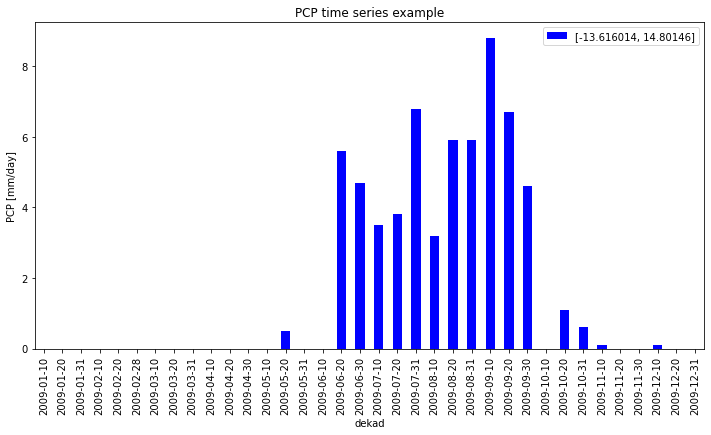

In [10]:
#Cell that generates a line graph from the Pandas dataframe. 

figs, ax = plt.subplots(1, figsize=(12, 6))

df.plot.bar(ax=ax,x='dekad',y='value',color='blue',label=str(point))
ax.set_ylabel('PCP [mm/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('PCP time series example')

## 4.2 PCP time series for multiple locations
The previous extraction was focussed on a single location. Next we will run a script for multiple location or pixel extractions and visualize the outputs. The locations here follow a latidudinal gradient, feel free to enter your own locations of interest.

In [11]:
#Define a dictionary of geo-locations in Lat/Lon coordinates. 
#You can give each pixel a name that will be used in the time series plot. 
#The extraction can take a few moments (usually < 2 min)

#For this example we are going to look at the monthly precipitation, 
#therefore our cube_code, measure and dimension need to be adjusted

cube_code = "L1_PCP_M"
#get datacube measure
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
resp=requests.get(cube_url).json()
measure=resp['response']['items'][0]['code']
#get datacube time dimension
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
resp=requests.get(cube_url).json()
items=pd.DataFrame.from_dict(resp['response']['items'])
dimension=items[items.type=='TIME']['code'].values[0]

# Define the locations of interest

points_dict = {'Chad_centre': [14.756,18.851], # [lat,lon]
               'DRC_centre':[-1.9541,22.0243],
               'Botswana_centre':[-22.312,24.740],
               'South_Africa_south': [-34.459,19.838]}

# Loop over all the points in points_dict

for i,point_name in enumerate(points_dict): 
    x = points_dict[point_name][1]
    y = points_dict[point_name][0]

    print(x,y)
    query_pixeltimeseries={
      "type": "PixelTimeSeries",
      "params": {
        "cube": {
          "code": cube_code,
          "workspaceCode": workspace,
          "language": "en"
        },
        "dimensions": [
          {
            "code": dimension,
            "range": "[2009-01-01,2019-01-01)"
          }
        ],
        "measures": [
          measure
        ],
        "point": {
          "crs": crs, #latlon projection              
          "x":x,
            "y":y
        }
      }
    }

    resp_query=requests.post(path_query,json=query_pixeltimeseries)
    resp_vp=resp_query.json()
    if resp_vp['message']=='OK': 
        results=resp_vp['response']
        df=pd.DataFrame(results['items'],columns=['Date',point_name])        
        if i==0:
            df_all=df
        else:
            df_all=pd.merge(df_all,df)        
    else:
        print(resp_vp['message'])
          
df_all

18.851 14.756
22.0243 -1.9541
24.74 -22.312
19.838 -34.459


,Date,Chad_centre,DRC_centre,Botswana_centre,South_Africa_south
0,2009-01-31,0.0,163.9,158.8,15.7
1,2009-02-28,0.0,107.1,89.6,41.7
2,2009-03-31,0.0,179.3,62.1,17.0
3,2009-04-30,1.2,141.5,6.6,31.8
4,2009-05-31,2.6,170.6,7.0,42.0
...,...,...,...,...,...
115,2018-08-31,89.9,190.1,0.6,64.2
116,2018-09-30,25.1,205.3,6.8,42.5
117,2018-10-31,0.0,247.2,12.2,17.0
118,2018-11-30,0.0,246.0,8.0,26.4


Text(0.5, 1.0, 'Monthly PCP time series example')

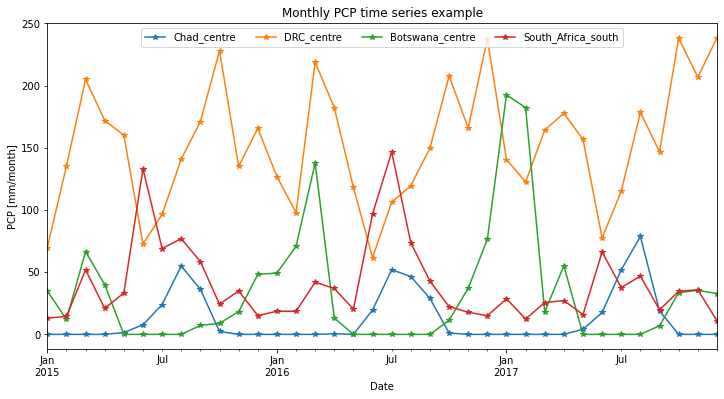

In [12]:
#Plot all time series and interpret the outcomes:
# Are there big differences amongst the locations? And can you explain them?

start_date = '2015-01-01'
end_date = '2017-12-31'

df_all.index=pd.to_datetime(df_all['Date'],format='%Y-%m-%d') #conver 'Date' column from string to datetime format

df_all_selection = df_all[start_date:end_date]

figs, ax = plt.subplots(1, figsize=(12, 6))

for i,point_name in enumerate(points_dict):
    df_all_selection[point_name].plot(ax=ax,label=point_name,marker='*')

ax.set_ylabel('PCP [mm/month]')
ax.legend(loc='upper center', ncol=5)
ax.set_title('Monthly PCP time series example')

# 5. Area statistics time series with Actual EvapoTranspiration and Interception (AETI)

Up until now we ony focussed on the time serie of a single pixel. Imaginge you want to evaluate a parameter over a larger area throughout time. statistics like, mean, min, max and range can be calculated using code in the following section.

In order to use this workflow, you will need to ask access through your WaPOR personal API key. This is the key for you to log in WaPOR server with your account instead of using password. You can generate one from WaPOR portal - profile page: https://wapor.apps.fao.org/profile

## 5.1 Enter your APIToken

In [41]:
path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
path_sign_in=r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'

APIToken=input('Your API token: ')

## 5.2 Get Authorization AccessToken

Use the input API token to get AccessToken for authorization

In [42]:
resp_signin=requests.post(path_sign_in,headers={'X-GISMGR-API-KEY':APIToken})
resp_signin = resp_signin.json()
AccessToken=resp_signin['response']['accessToken']
AccessToken

'eyJhbGciOiJSUzI1NiIsImtpZCI6IjA2M2E3Y2E0M2MzYzc2MDM2NzRlZGE0YmU5NzcyNWI3M2QwZGMwMWYiLCJ0eXAiOiJKV1QifQ.eyJuYW1lIjoiQ2hyaXN0b3BoZSBNZXRzdSIsImlzcyI6Imh0dHBzOi8vc2VjdXJldG9rZW4uZ29vZ2xlLmNvbS91bmZhby1hcHBzLWRldiIsImF1ZCI6InVuZmFvLWFwcHMtZGV2IiwiYXV0aF90aW1lIjoxNjYwMTQ2NzE4LCJ1c2VyX2lkIjoidHg3Y3A5NVpyeFBUWDBDU25aeTBkMklIZUdtMiIsInN1YiI6InR4N2NwOTVacnhQVFgwQ1NuWnkwZDJJSGVHbTIiLCJpYXQiOjE2NjAxNDY3MTgsImV4cCI6MTY2MDE1MDMxOCwiZW1haWwiOiJjaHJpc3RvcGhlbWV0c3VAaG90bWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiZmlyZWJhc2UiOnsiaWRlbnRpdGllcyI6eyJlbWFpbCI6WyJjaHJpc3RvcGhlbWV0c3VAaG90bWFpbC5jb20iXX0sInNpZ25faW5fcHJvdmlkZXIiOiJjdXN0b20ifX0.F6Oc8P8xzl158T7whhEZRaJ8y_59qtGao4ICXbsbyDMSMA3JEHC9zm5nhu_EseG0kmt7q81k5V_hbGoEHt3SOfijibrK6lp4GOdnOkjRNk4yNyK3rCpUVL0nwWxBx6eeHcwHTGZSqAW334q0epuRoyNc3YPEKhzdfJ0J-o6fFJM2HlFn-xL7JAEDCIS_rbqUzQ4qqAlCUAHztq3RPionpCPDGWwOJFQAxvWNG-00oB5MBUkyL-eqd6WSl7YHTljd5r1FCmjBdj6tVfcW7jdTlFKNvLUlRaIaxXZK9bqeTlNb-dTn9nHujkFKlgErYl-sfIrngl0onP3FR7kE79-ecA'

## 5.3 Write Query Payload

For more examples of areatimeseries query load 
visit https://io.apps.fao.org/gismgr/api/v1/swagger-ui/examples/AreaStatsTimeSeries.txt

In [43]:
crs="EPSG:4326" #coordinate reference system
cube_code="L1_AETI_D" # Dekadal actual evapotraspiration and interception on L1 level
workspace='WAPOR_2'
start_date="2009-01-01"
end_date="2019-01-01"

#get datacube measure
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
resp=requests.get(cube_url).json()
measure=resp['response']['items'][0]['code']
print('MEASURE: ',measure)

#get datacube time dimension
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
resp=requests.get(cube_url).json()
items=pd.DataFrame.from_dict(resp['response']['items'])
dimension=items[items.type=='TIME']['code'].values[0]
print('DIMENSION: ',dimension)

MEASURE:  WATER_MM
DIMENSION:  DEKAD


### Define area of interest

Before we make the query we need to define the area of interest. This can be done on two ways: 
 - Define the area by a bbox coordinate extent
 - Define the area by reading a GeoJSON file (shapefile)

#### The bbox version (our approach for now):

In [44]:
# Define the area based on a bbox coordinate extent

bbox= [37.95883206252312, 7.89534, 43.32093, 12.3873979377346] #latlon
xmin,ymin,xmax,ymax=bbox[0],bbox[1],bbox[2],bbox[3]
Polygon=[
          [xmin,ymin],
          [xmin,ymax],
          [xmax,ymax],
          [xmax,ymin],
          [xmin,ymin]
        ]
query_areatimeseries={
  "type": "AreaStatsTimeSeries",
  "params": {
    "cube": {
      "code": cube_code, #cube_code
      "workspaceCode": workspace, #workspace code: use WAPOR for v1.0 and WAPOR_2 for v2.1
      "language": "en"
    },
    "dimensions": [
      {
        "code": dimension, #use DAY DEKAD MONTH or YEAR
        "range": f"[{start_date},{end_date})" #start date and endate
      }
    ],
    "measures": [
      measure
    ],
    "shape": {
      "type": "Polygon",
      "properties": {
      "name": crs #coordinate reference system
              },
      "coordinates": [
       Polygon
      ]
    }
  }
}

query_areatimeseries

{'type': 'AreaStatsTimeSeries',
 'params': {'cube': {'code': 'L1_AETI_D',
   'workspaceCode': 'WAPOR_2',
   'language': 'en'},
  'dimensions': [{'code': 'DEKAD', 'range': '[2009-01-01,2019-01-01)'}],
  'measures': ['WATER_MM'],
  'shape': {'type': 'Polygon',
   'properties': {'name': 'EPSG:4326'},
   'coordinates': [[[37.95883206252312, 7.89534],
     [37.95883206252312, 12.3873979377346],
     [43.32093, 12.3873979377346],
     [43.32093, 7.89534],
     [37.95883206252312, 7.89534]]]}}}

#### OR use the following code in case of a GeoJSON file:

In [ ]:
# # Uncomment the following lines to run this cel (select lines and press ctrl + /)

# import ogr
# shp_fh=r"path_to_file\shapefile.shp" # e.g. .\data\basin_shapefile.shp

# shpfile=ogr.Open(shp_fh)
# layer=shpfile.GetLayer()
# epsg_code=layer.GetSpatialRef().GetAuthorityCode(None)
# shape=layer.GetFeature(0).ExportToJson(as_object=True)['geometry'] #get geometry of shapefile in JSON string
# shape["properties"]={"name": "EPSG:{0}".format(epsg_code)}#latlon projection            

# query_areatimeseries={
#   "type": "AreaStatsTimeSeries",
#   "params": {
#     "cube": {
#       "code": cube_code,
#       "workspaceCode": workspace,
#       "language": "en"
#     },
#     "dimensions": [
#       {
#         "code": dimension,
#         "range": f"[{start_date},{end_date})"
#       }
#     ],
#     "measures": [
#       measure
#     ],
#     "shape": shape
#   }
# }

# query_areatimeseries

## 5.4 Post the QueryPayload with AccessToken in Header 

In responses, get an url to query job. 

In [45]:
resp_query=requests.post(path_query,headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                          json=query_areatimeseries)
resp_query = resp_query.json()
job_url=resp_query['response']['links'][0]['href']

job_url

'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR_2/jobs/aa0d15fe-3b83-4e5d-ba38-25f216e9cc4b'

## 5.5 Get Job Results.

It will take some time for the job to be finished. When the job is finished, its status will be changed from 'RUNNING' to 'COMPLETED' or 'COMPLETED WITH ERRORS'. If it is COMPLETED, the area time series results can be achieved from Response 'output'.

In [46]:
i=0
print('RUNNING',end=" ")
while i==0:        
    resp = requests.get(job_url)
    resp=resp.json()
    
    if resp['response']['status']=='RUNNING':
        print('.',end =" ")
    if resp['response']['status']=='COMPLETED':
        results=resp['response']['output']
        df=pd.DataFrame(results['items'],columns=results['header'])
        i=1
    if resp['response']['status']=='COMPLETED WITH ERRORS':
        print(resp['response']['log'])
        i=1       
df

RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

,dekad,avg,min,max,range
0,2009-01-10,1.139956,0.0,8.6,8.6
1,2009-01-20,1.193750,0.0,6.6,6.6
2,2009-01-31,1.285700,0.0,7.0,7.0
3,2009-02-10,1.260122,0.0,9.1,9.1
4,2009-02-20,1.343921,0.0,9.5,9.5
...,...,...,...,...,...
355,2018-11-20,1.746505,0.0,7.5,7.5
356,2018-11-30,1.504676,0.0,7.6,7.6
357,2018-12-10,1.489926,0.0,7.7,7.7
358,2018-12-20,1.342157,0.0,8.0,8.0


## 5.6 Plot results

Text(0.5, 1.0, 'AETI per day for each dekad time series example')

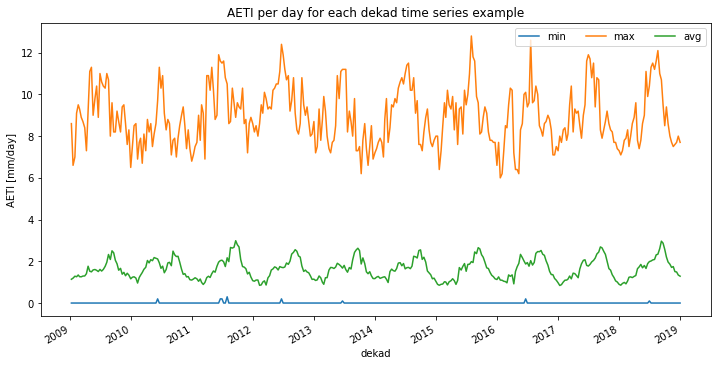

In [50]:
df.index=pd.to_datetime(df['dekad'],format='%Y-%m-%d')

figs, ax = plt.subplots(1, figsize=(12, 6))
df['min'].plot(ax=ax, label='min')
df['max'].plot(ax=ax, label='max')
df['avg'].plot(ax=ax, label='avg')

ax.set_ylabel('AETI [mm/day]')
ax.legend(loc='upper right', ncol=5)
ax.set_title('AETI per day for each dekad time series example')

# 6. Extraction of TIFF files

In the following section we shift our focus away from timeseries and look how we can download a cropped rasterfile of one of the WaPOR products. The procedure is very similar to previous section. Here we will again make use of our personal APIToken. Check section 5. 
Part 6.1 and 6.2 can be skipped if you already ran 5.1 and 5.2.

As an example we will demonstrate how to download the L2 seasonal phenology product (PHE).

## 6.1 Enter your APIToken 

In [59]:
path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
path_sign_in=r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'

APIToken=input('Your API token: ')

## 6.2 Get Authorization AccessToken

In [60]:
resp_signin=requests.post(path_sign_in,headers={'X-GISMGR-API-KEY':APIToken})
resp_signin = resp_signin.json()
AccessToken=resp_signin['response']['accessToken']
AccessToken

'eyJhbGciOiJSUzI1NiIsImtpZCI6IjA2M2E3Y2E0M2MzYzc2MDM2NzRlZGE0YmU5NzcyNWI3M2QwZGMwMWYiLCJ0eXAiOiJKV1QifQ.eyJuYW1lIjoiQ2hyaXN0b3BoZSBNZXRzdSIsImlzcyI6Imh0dHBzOi8vc2VjdXJldG9rZW4uZ29vZ2xlLmNvbS91bmZhby1hcHBzLWRldiIsImF1ZCI6InVuZmFvLWFwcHMtZGV2IiwiYXV0aF90aW1lIjoxNjYwMjA0NTE1LCJ1c2VyX2lkIjoidHg3Y3A5NVpyeFBUWDBDU25aeTBkMklIZUdtMiIsInN1YiI6InR4N2NwOTVacnhQVFgwQ1NuWnkwZDJJSGVHbTIiLCJpYXQiOjE2NjAyMDQ1MTUsImV4cCI6MTY2MDIwODExNSwiZW1haWwiOiJjaHJpc3RvcGhlbWV0c3VAaG90bWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwiZmlyZWJhc2UiOnsiaWRlbnRpdGllcyI6eyJlbWFpbCI6WyJjaHJpc3RvcGhlbWV0c3VAaG90bWFpbC5jb20iXX0sInNpZ25faW5fcHJvdmlkZXIiOiJjdXN0b20ifX0.TM4vlMHpRjFlM58AWjNuQixwPNTdqMesvnpdzDRpC_JN0KMR0oC7myTv60zCo58yEjNxUMsWtgNRRWApZtpvYZM3L04mhgvGm3J9JtEBLSTw-ygn_kU-Fh__CzJy1EDjatsy-oCZYbrOicm4FPnDxnYdvYnkAdYWRgqOAxoyHCYaDgGZfR6k3Pm9KLVsPANKzeQk28cRYo2ex1vVyzF06iX6aR_ZJqmGZ7HIaqX2yoJ53Oemv8nJGDzgnFg1ryToUL0XJTaJjAhuHs0jw2lpqrKHKNJ4thgB5srF9HGsKJsT_NZ5uCGNJfnml8wdJAnRWkB5QMrDcpOjGvxkiq2aoA'

## 6.3 Post Query Payload

In [61]:
cube_code='L2_PHE_S'
workspace='WAPOR_2'
outputFileName='L2_PHE_17s1_s_clipped.tif' # indicate how you want to name your rasterfile

#get datacube measure
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/measures'
resp=requests.get(cube_url).json()
measure=resp['response']['items'][0]['code']
print('MEASURE: ',measure)

#get datacube time dimension
cube_url=f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes/{cube_code}/dimensions'
resp=requests.get(cube_url).json()
items=pd.DataFrame.from_dict(resp['response']['items'])
items

MEASURE:  PHE


,code,caption,workspaceCode,hierarchical,type,index,links
0,YEAR,Year,WAPOR_2,False,TIME,1,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,SEASON,Season,WAPOR_2,False,WHAT,2,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
2,STAGE,Growing Stage,WAPOR_2,False,WHAT,3,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


Set dimensions values to identify the raster data needed.

In [62]:
year="[2017-01-01,2018-01-01)" # specify which the year of which you want to retrieve the data
stage="SOS" # Start of season
season="S1" # first season (note not all regions have two seasons in 1 year)

### Define area of interest

Before we make the query we need to define the area of interest. This can be done on two ways: 
 - Define the area by a bbox coordinate extent
 - Define the area by reading a GeoJSON file (shapefile)

#### The bbox version (our approach for now):

In [63]:
bbox= [37.95883206252312, 7.89534, 43.32093, 12.3873979377346] #latlon
xmin,ymin,xmax,ymax=bbox[0],bbox[1],bbox[2],bbox[3]
Polygon=[
          [xmin,ymin],
          [xmin,ymax],
          [xmax,ymax],
          [xmax,ymin],
          [xmin,ymin]
        ]

query={
  "type": "CropRaster",
  "params": {
    "properties": {
      "outputFileName": outputFileName,
      "cutline": True,
      "tiled": True,
      "compressed": True,
      "overviews": True
    },
    "cube": {
      "code": cube_code,
      "workspaceCode": workspace,
      "language": "en"
    },
    "dimensions": [
      {
        "code": "SEASON",
        "values": [
          season
        ]
      },
      {
        "code": "STAGE",
        "values": [
          stage
        ]
      },
      {
        "code": "YEAR",
        "values": [
          year
        ]
      }
    ],
    "measures": [
      measure
    ],
    "shape": {
      "type": "Polygon",
      "coordinates": [Polygon]
    }
  }
}

#### OR use the following code in case of a GeoJSON file:

In [ ]:
# # Uncomment the following lines to run this cel (select lines and press ctrl + /)

# import ogr
# shp_fh=r"path_to_file\shapefile.shp" # e.g. .\data\basin_shapefile.shp

# shpfile=ogr.Open(shp_fh)
# layer=shpfile.GetLayer()
# epsg_code=layer.GetSpatialRef().GetAuthorityCode(None)
# shape=layer.GetFeature(0).ExportToJson(as_object=True)['geometry']
# shape["properties"]={"name": "EPSG:{0}".format(epsg_code)}#latlon projection            

# query={
#   "type": "CropRaster",
#   "params": {
#     "properties": {
#       "outputFileName": outputFileName,
#       "cutline": True,
#       "tiled": True,
#       "compressed": True,
#       "overviews": True
#     },
#     "cube": {
#       "code": cube_code,
#       "workspaceCode": workspace,
#       "language": "en"
#     },
#     "dimensions": [
#       {
#         "code": "SEASON",
#         "values": [
#           season
#         ]
#       },
#       {
#         "code": "STAGE",
#         "values": [
#           stage
#         ]
#       },
#       {
#         "code": "YEAR",
#         "values": [
#           year
#         ]
#       }
#     ],
#     "measures": [
#       measure
#     ],
#     "shape": shape
#   }
# }

## 6.4 Post the QueryPayload with AccessToken in Header 

In responses, get an url to query job. 

In [64]:
resp_query=requests.post(path_query,headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                          json=query)
resp_query = resp_query.json()
job_url=resp_query['response']['links'][0]['href']

job_url

'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR_2/jobs/daa37b9a-4c8b-49b2-b724-afdb46d864d7'

## 6.5 Get job results

It will take some time for the job to be finished. When the job is finished, its status will be changed from 'RUNNING' to 'COMPLETED' or 'COMPLETED WITH ERRORS'. If it is COMPLETED, the url to download raster can be achieved from Response 'output'. Paste this url in your browser to download the raster file. Afterwards you can move it to your desired location.

In [65]:
i=0
print('RUNNING',end=" ")
while i==0:        
    resp = requests.get(job_url)
    resp=resp.json()
    
    if resp['response']['status']=='RUNNING':
        print('.',end =" ")
    if resp['response']['status']=='COMPLETED':
        results=resp['response']['output']
        print(resp['response']['output'])
        i=1
    if resp['response']['status']=='COMPLETED WITH ERRORS':
        print(resp['response']['log'])
        i=1  

RUNNING . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . {'downloadUrl': 'https://io.apps.fao.org/gismgr/download/0e7523de-1cec-4850-afe8-e6e2e6e2dd34/L2_PHE_17s1_s_clipped.tif'}


# 7. Other Workspaces

As seen in section 3.1, the FAO Map Catalog offers more than WaPOR data. Some usefull drought related data can also be found in the ASIS workspace. Have a look at the datacubes available in the ASIS workspace:

In [66]:
# List of workspace cubes? 

workspace='ASIS'
overview=False
paged=False
cubes_url= f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp=requests.get(cubes_url).json()
catalog=pd.DataFrame.from_dict(resp['response'])
catalog

,code,caption,description,additionalInfo,workspaceCode,dataType,index,operation,hidden,links,tags
0,PRO,Progress of Season,The indicator depicts the development of crops...,"{'flags': [{'value': 250, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
1,VHI_D,Vegetation Health Index (Dekadal),The Vegetation Health Index (VHI) illustrates ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
2,VHI_M,Vegetation Health Index (Monthly),The Vegetation Health Index (VHI) illustrates ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
3,HDF,Historic Drought Frequency,Historic Agricultural Drought Frenquecy Maps d...,"{'flags': [{'value': 251, 'description': 'inco...",ASIS,RASTER,1,"{'pixelTimeSeries': False, 'areaStats': False}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
4,ASI_A,Agricultural Stress Index (Annual),The Annual ASI depicts the percentage of arabl...,"{'flags': [{'value': 251, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
5,ASI_D,"Agricultural Stress Index (Near Real Time, Dek...",The Agricultural Stress Index (ASI) is a quick...,"{'flags': [{'value': 251, 'description': 'off ...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
6,VCI_M,Vegetation Condition Index (Monthly),The Vegetation Condition Index (VCI) evaluates...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
7,DI_A,Drought Intensity (Annual),Agricultural droughts are classified by their ...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
8,VCI_D,Vegetation Condition Index (Dekadal),The Vegetation Condition Index (VCI) evaluates...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN
9,MVHI_A,Mean Vegetation Health Index (Annual),The Mean Vegetation Health Index (Mean VHI) al...,"{'epsg': 4326, 'size': [40320, 14673], 'flags'...",ASIS,RASTER,1,"{'pixelTimeSeries': True, 'areaStats': True}",False,"[{'rel': 'self', 'href': 'https://io.apps.fao....",NaN


Another interesting dataset is the WPOP. It provides rasters with population density and count and can be used to link the number of people affected by a drought. 

In [67]:
# List of workspace cubes? 

workspace='WPOP'
overview=False
paged=False
cubes_url= f'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/{workspace}/cubes?overview={overview}&paged={paged}'
resp=requests.get(cubes_url).json()
catalog=pd.DataFrame.from_dict(resp['response'])
catalog

,code,caption,description,additionalInfo,tags,workspaceCode,dataType,index,operation,hidden,links
0,WPOP_T,Total Population,Estimated total number of people per grid-cell...,"{'format': 'Raster Dataset', 'unit': 'ppl', 'd...","[{'name': 'L1', 'context': 'LEVELS_LIST'}, {'n...",WPOP,RASTER,1,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."
1,WPOP_D,Human Population Density,Estimated density of people per grid-cell. The...,"{'format': 'Raster Dataset', 'unit': 'ppl/Km²'...","[{'name': 'L1', 'context': 'LEVELS_LIST'}, {'n...",WPOP,RASTER,2,"{'pixelTimeSeries': True, 'areaStatsTimeSeries...",False,"[{'rel': 'self', 'href': 'https://io.apps.fao...."


In order to retrieve the data of interest please follow the steps in previous sections by altering the workspace (cubes), coordinates, timeframes, dimension and measures and so on. 

Thank you for your attention and feel free explore more datasets!